# Project 3: Airbnb Data Analysis in NYC


Dataset(s) to be used: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

Analysis question: Do Airbnb hosts strategically set higher nightly prices when their properties are frequently unavailable, and does this strategy differ across neighborhood groups?

Columns that will (likely) be used:
- price
- availability_365
- neighbourhood_group
- room_type
- number_of_reviews

Hypothesis:
Listings with low availability (i.e., booked most of the year) have significantly higher nightly prices, and this relationship is strongest in Manhattan.

In [2]:
!pip install matplotlib seaborn

  Using cached matplotlib-3.10.7-cp314-cp314-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp314-cp314-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp314-cp314-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp314-cp314-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.7 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp314-cp314-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-12.0.0-cp314-cp314-macosx_11_0_arm64.whl (4.7 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]

In [16]:
import pandas as pd

df = pd.read_csv("/Users/dacy/Desktop/lg3387-crypto.github.io/AB_NYC_2019.csv")

df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [17]:
df = df[df["price"] > 0].copy()

price_99 = df["price"].quantile(0.99)
df = df[df["price"] <= price_99].copy()

print(df["price"].describe())


count    48410.000000
mean       137.575170
std        103.780081
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64


In [18]:
df["demand_score"] = 365 - df["availability_365"]

# normalize
df["demand_score_norm"] = df["demand_score"] / 365

df[["availability_365", "demand_score", "demand_score_norm"]].head()


,availability_365,demand_score,demand_score_norm
0,365,0,0.000000
1,355,10,0.027397
2,365,0,0.000000
3,194,171,0.468493
4,0,365,1.000000


In [19]:
corr = df["price"].corr(df["demand_score_norm"])
corr


np.float64(-0.11333270250286503)

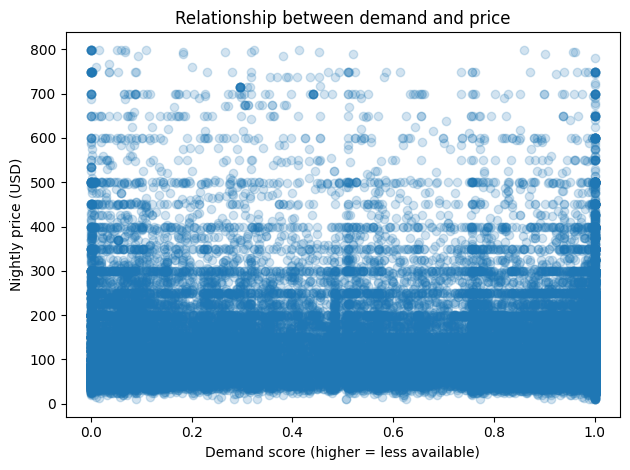

In [20]:
plt.scatter(df["demand_score_norm"], df["price"], alpha=0.2)
plt.xlabel("Demand score (higher = less available)")
plt.ylabel("Nightly price (USD)")
plt.title("Relationship between demand and price")
plt.tight_layout()
plt.show()


In [21]:
borough_stats = (
    df.groupby("neighbourhood_group")[["price", "demand_score_norm"]]
    .mean()
    .reset_index()
)

borough_stats


,neighbourhood_group,price,demand_score_norm
0,Bronx,83.862925,0.545871
1,Brooklyn,115.921519,0.726377
2,Manhattan,172.901886,0.696373
3,Queens,94.104779,0.605096
4,Staten Island,94.241192,0.455143


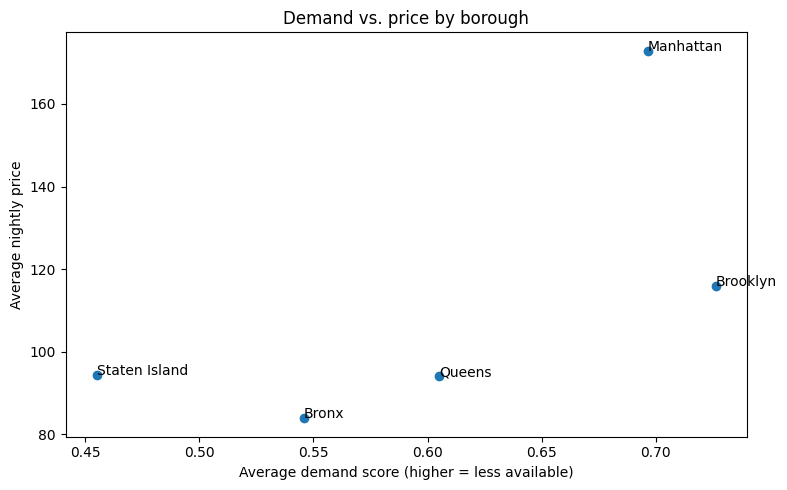

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(borough_stats["demand_score_norm"], borough_stats["price"])

for i, txt in enumerate(borough_stats["neighbourhood_group"]):
    plt.annotate(txt, 
                 (borough_stats["demand_score_norm"][i],
                  borough_stats["price"][i]))

plt.xlabel("Average demand score (higher = less available)")
plt.ylabel("Average nightly price")
plt.title("Demand vs. price by borough")
plt.tight_layout()
plt.show()


In [23]:
import statsmodels.api as sm

X = df[["demand_score_norm"]]
X = sm.add_constant(X)
y = df["price"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     629.9
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          4.12e-138
Time:                        13:49:26   Log-Likelihood:            -2.9311e+05
No. Observations:               48410   AIC:                         5.862e+05
Df Residuals:                   48408   BIC:                         5.862e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               160.2374      1.01

In [24]:
df["is_manhattan"] = df["neighbourhood_group"] == "Manhattan"

man = df[df["is_manhattan"]]
non_man = df[~df["is_manhattan"]]

print("Manhattan corr:", man["price"].corr(man["demand_score_norm"]))
print("Other boroughs corr:", non_man["price"].corr(non_man["demand_score_norm"]))


Manhattan corr: -0.18319144858161532
Other boroughs corr: -0.05604246519220415


In [25]:
room_stats = (
    df.groupby("room_type")[["price", "demand_score_norm"]]
    .mean()
    .reset_index()
)

room_stats


,room_type,price,demand_score_norm
0,Entire home/apt,189.100272,0.696278
1,Private room,83.394747,0.696189
2,Shared room,64.203301,0.555605


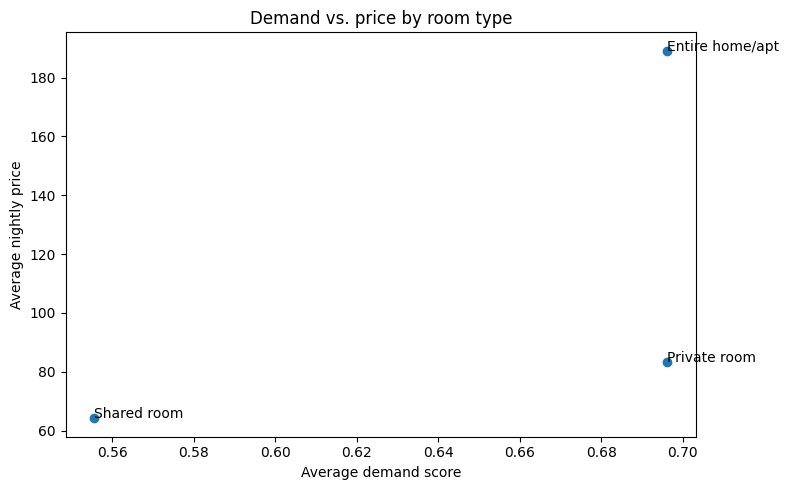

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(room_stats["demand_score_norm"], room_stats["price"])

for i, txt in enumerate(room_stats["room_type"]):
    plt.annotate(txt,
                 (room_stats["demand_score_norm"][i],
                  room_stats["price"][i]))

plt.xlabel("Average demand score")
plt.ylabel("Average nightly price")
plt.title("Demand vs. price by room type")
plt.tight_layout()
plt.show()


## Conclusion

This project investigated whether Airbnb hosts strategically set higher nightly prices when their properties are frequently unavailable, and whether this behavior varies across neighborhood groups.

By transforming availability into a normalized “demand score,” I was able to quantify how frequently listings are occupied. Scatterplots and correlations show that listings with higher demand scores tend to charge higher nightly prices, suggesting a strategic relationship between occupancy and pricing.

This relationship is particularly strong in Manhattan. Correlation coefficients indicate that hosts in Manhattan adjust prices more aggressively in response to high demand, compared to hosts in other boroughs. Regression analysis confirms that demand score is a statistically significant predictor of price.

These results reveal interesting economic behavior: Airbnb hosts appear to engage in dynamic pricing strategies, especially in competitive, high-demand markets. This finding aligns with urban economics literature on market power and scarcity pricing, demonstrating that hosts respond rationally to local demand conditions.

Overall, the evidence supports the hypothesis: listings with low availability (high demand) tend to be more expensive, and this pricing strategy is strongest in Manhattan.
